## Simulation Design 
###  Based on the code of EIP-1559 valuation system from last semester
- for single spike simulation
    - When an NFT drops, large amounts of transactions suddenly flood into the mempool with much higher valuations. 
    - increase a lump of txs into the mempool at 25th block (start point) 
    - increase value and gas_limit -- n size larger 
    - back to normal
- for daily basefee spike number 
    -  The simulation follows a Poisson distribution with the duration of 24 hours which takes roughly 5,000 blocks. The data was collected from Sep with an estimated daily base fee spike mean of 2 (Please check CountSpikes_Sep.ipynb for how we counted spkies).


# Congestion Simulation

We simulate the ethereum market in both the status quo and under EIP-1559. Both simulations draw from the same distribution of "values", which quantify the amount that users inherently value their transaction. Both simulations also draw from the same "gas used" distributions.

We first import the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import math
from collections import deque
import matplotlib.pyplot as plt
import cProfile
import random

Throughout the simulation, we keep track of blocks filled and oracle prediction values generated. 

In [2]:
sq_current_oracle = 0
eip_current_oracle = 0 

sq_blocks = []
eip_blocks = []

sq_block_mins =  deque([])
eip_block_mins = deque([])

sq_gas_price_batches = []
eip_gas_price_batches = []

sq_wait_times =[]
eip_wait_times=[]

At every iteration of the simulation, a block is filled with the most lucrative transactions in the mempool, and the mempool is filled again with 2000 transactions. In the function defined below, 2000 samples are taken from the "values" and "gas used" distributions, price mapped to Status Quo and EIP-1559 simulations, and added to the existing mempool. 

In [3]:
def create_mempool(txn_number, sq_df, eip_df, basefee,gas_congestion_size, price_congestion_size, t=0):
  
    global sq_current_oracle, eip_current_oracle, sq_gas_price_batches, eip_gas_price_batches
    
    ## adjust values and gas_limit with price_congestion_size and gas_congestion_size 
    ## based on the post-eip data -- n times lager than the regular biddings
    
    values = np.random.gamma(20.72054, 1/17.49951, txn_number) * price_congestion_size
    # values = [x * random.randint(1, price_congestion_size) for x in values]
    gas_limit = (np.random.pareto(1.42150, txn_number)+1)*21000* gas_congestion_size   # pareto distribution with alpha 1.42150, beta 21000
     
    
    sq_gas_prices = [sq_current_oracle * v for v in values] 
    eip_gas_prices = [min(basefee + (eip_current_oracle * v), sq_current_oracle * v) for v in values]   
    
    eip_gas_price_batches += [eip_gas_prices]
    sq_gas_price_batches += [sq_gas_prices]
    
    # store each updated mempool as a DataFrame

    sq_df = sq_df.append(pd.DataFrame({
        'gas price': sq_gas_prices,
        'gas limit': gas_limit,
        'time' : t,
        'amount paid': [x * y for x,y in zip(sq_gas_prices,gas_limit)]
        }), ignore_index=True)
    

    eip_df = eip_df.append(pd.DataFrame({
        'gas price': eip_gas_prices,
        'gas limit': gas_limit,
        'time': t,
        'amount paid' : [x * y for x,y in zip(eip_gas_prices,gas_limit)]
        }), ignore_index=True)
    
    # sort transactions in each mempool by gas price
    
    sq_df = sq_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    eip_df = eip_df.sort_values(by=['gas price'], ascending=False).reset_index(drop=True)
    
    return sq_df, eip_df

We define some helper functions. First, a function to calculate a new basefee. Second, a function to update the oracle values for each transaction. We create a sorted list of the smallest (lowest gas-price) transactions from the previous hundred blocks. The oracle value is defined as the 60th item in that list. Finally, we need functions to fill blocks for both simulations. Because the protocols have different rules on this, we pass a basefee of 0 in the Status Quo simulation and pass in the actual basefee in the EIP-1559 simulation. 

In [4]:
def get_basefee(b, g): 
    print(b)
    return b*(1+(1/8)*((g-15000000)/15000000))

def get_oracle():
    
    global sq_current_oracle, sq_block_mins, sq_blocks, eip_block_mins, eip_current_oracle, eip_blocks
    
    #sq_current_oracle = update_oracle(sq_current_oracle, sq_block_mins, sq_blocks)
    eip_current_oracle = update_oracle(eip_current_oracle, eip_block_mins, eip_blocks)

def update_oracle(current_oracle, block_minimums, blocks):
    if len(blocks[-1]) == 0:
        recent_gp = 0
    else:
        recent_gp = blocks[-1][-1][0]
    block_minimums.popleft()
    block_minimums.append(recent_gp)

    sorted_block_minimums = sorted(block_minimums)
  
    return sorted_block_minimums[59]

def fill_block(mempool, basefee, time):
    global eip_wait_times, sq_wait_times
    
    block = []
    block_size = 0
    block_limit = 30000000 if basefee > 0 else 15000000
    
    for i in range(len(mempool)):
        txn = mempool.iloc[i, :].tolist()
        if block_size + txn[1] > block_limit or txn[0] < basefee:
            # print(txn[0] < basefee, txn[0], basefee)
            break
        else:
            block.append(txn)
            block_size += txn[1]
    
    block_wait_times = [time - txn[2] for txn in block]
    if basefee:
        eip_wait_times.append(block_wait_times)
    else:
        sq_wait_times.append(block_wait_times)
    
    #remove verified txns from mempool
    mempool = mempool.iloc[i+1:,:]    
    return block, mempool, block_size

New added function -- The daily spike number simulation is ran in the following function, storing data on each iteration. 

In [6]:
def pending_tx_sizes(n):
    number_of_spikes = int(np.random.poisson(lam = 2,size = 1))
    print(number_of_spikes)
    if number_of_spikes == 0:
        return [random.randint(100, 400) for _ in range(n)], [1 for _ in range(n)], [1 for _ in range(n)]

    # all spikes 
    spikes = [random.randint(0, n-1) for _ in range(number_of_spikes)]
    print(spikes)
    values = [None for _ in range(n)]  # n values of None 
    price_congestion = [1 for _ in range(n)]
    gas_congestion = [1 for _ in range(n)]
    
    
    for i in range(n):   
        if values[i] == None:
            values[i] = random.randint(100, 400)
    for s in spikes:
        values[s] = random.randint(3000,12000)
        price_congestion[s]= random.randint(10,80)
        gas_congestion[s] = random.uniform(1.5,2)
    
    return values, gas_congestion, price_congestion

In [7]:
def simulate(n):
    
    #initialize empty dataframes
    df1 = pd.DataFrame() 
    df2 = pd.DataFrame() 
    
    sq_block_data = pd.DataFrame()
    eip_block_data = pd.DataFrame()
   
    sq_mempool_data = pd.DataFrame()
    eip_mempool_data = pd.DataFrame()
    
  
    sq_mempools = []
    eip_mempools = []
    eip_mempools_bf = []
    demands = []
    
    global sq_block_mins, eip_block_mins, sq_blocks, sq_current_oracle, eip_current_oracle, eip_blocks, eip_wait_times, sq_wait_times
    
    #read in data to initialize oracle
    data = pd.read_csv('block_data.csv')
    minGasdf = data[['gasLimit','minGasPrice']].values 
    for d in minGasdf:
        if len(eip_block_mins) == 100:
            break
        if d[1] == 'None':
            continue
        sq_block_mins.append(int(d[1]) / 10**9)
        eip_block_mins.append(int(d[1]) / 10**9)
    
    basefee = eip_block_mins[-1]
    basefees = [basefee]
    
    sorted_sq_block_mins = sorted(sq_block_mins)
    sorted_eip_block_mins = sorted([x - basefee if x >= basefee else 0 for x in eip_block_mins])
    
    #set initial oracles
    sq_current_oracle = sorted_sq_block_mins[59]
    eip_current_oracle = sorted_eip_block_mins[59]
    
    #initialize mempools with 700 txns
    sq_mempool, eip_mempool = create_mempool(8500, df1, df2, basefee,1,1)
    
    
    new_txs_sizes, gas_congestions, price_congestions = pending_tx_sizes(n)
    
    #iterate over n blocks
    for i in range(n):
        
        #fill blocks from mempools
        new_eip_block, new_eip_mempool, eip_blocksize = fill_block(eip_mempool, basefee, i)
        new_sq_block, new_sq_mempool, sq_blocksize = fill_block(sq_mempool, 0, i)
        
        sq_blocks += [new_sq_block]
        eip_blocks += [new_eip_block]
        
        get_oracle()
        
        #update mempools
        sq_mempool = new_sq_mempool
        eip_mempool = new_eip_mempool
        basefee = get_basefee(basefee, eip_blocksize)
        basefees += [basefee]
        
#        sq_mempools += [sq_mempool]
#        eip_mempools += [eip_mempool]
#        eip_mempools_bf += [eip_mempool[eip_mempool['gas price'] >= basefee]]
        
        #add 200 new txns before next iteration
        new_demand = new_txs_sizes[i]
        price_congestion = price_congestions[i]
        gas_congestion = gas_congestions[i]
        sq_mempool, eip_mempool = create_mempool(new_demand, sq_mempool, eip_mempool, basefee, gas_congestion, price_congestion, i+1) #randomly select from 50 to 400
        
        demands += [new_demand]
        
        print("progress: ", i+1, end = '\r')
    return basefees, eip_blocks, sq_blocks, eip_mempools, sq_mempools, eip_mempools_bf, demands, eip_wait_times, sq_wait_times

We run the simulation and save the summary data.

In [8]:
s = simulate(5000)
basefees_data = s[0]
eip_blocks_data = s[1]
sq_blocks_data = s[2]
eip_mempools_data = s[3]
sq_mempools_data = s[4]
eip_mempools_bf_data = s[5]
demands = s[6]
eip_wait_times = s[7]
sq_wait_times = s[8]

# cProfile.run("simulate(100)")

2
[72, 4400]
38.100002694
42.85855381135308
41.682136863431154
40.38885426430691
38.14615583337126
39.84428519289029
38.92185330581448
38.436302313458974
36.41862720905489
40.8747046661326
41.75469732561375
42.25678078838152
39.34613532286656
39.687516772419
37.947285884314155
42.689418774026784
41.490448599594664
38.32520156225585
38.835929052823445
37.39596293550747
42.06683911176714
38.86872933424916
35.673207928007685
40.12390264868436
39.96769234876687
43.995507944095685
41.20711284815429
41.59317885128981
41.506751709888746
42.070132881787885
40.821373170471986
38.753829534497214
40.95821795626383
39.32288225388391
38.5255466647717
35.897604445628275
40.36892503213519
40.2601259474556
38.903785450077606
39.16221357535927
40.67603284872305
37.598200726728955
42.23409700857393
40.273580587630796
39.42318666303724
36.879688460187396
41.48453022537387
38.98090585026493
37.43296758390823
42.11203328589887
38.72923995216348
36.06438917612003
40.518786964468134
39.662326941781494
37.751

35.77133961013601
40.22353762072224
38.1430992646057
38.05516120271843
35.45101469978152
39.84072708886031
39.02335224411907
36.81168675130664
38.07866965049192
36.252690485938714
38.49811313135383
36.26983483148104
37.211901977482704
35.976859773757965
40.07900178847667
37.82356523257735
36.67769676380232
34.3094466891499
38.590053999556964
38.22600049856813
36.49721080607943
38.7487105774422
37.84620075295565
34.76046538901486
39.094983117310285
36.964600557422884
34.16590204924493
38.32410158677528
36.44537220710329
37.35553170675151
38.45791627982142
36.416937502889404
40.72673263967385
37.11894838728044
36.58018810922586
33.494982768787146
37.64317346219338
36.37924334323232
35.77572407182922
34.58475667100385
38.89448068587459
43.755063197514346
41.410608485034004
42.516993934359206
41.185888304546936
42.05592327037385
40.26385260055278
42.46083432817231
41.5274317255342
40.118550515325445
39.171434936997834
44.06581430971458
41.095937093636536
38.78940731066808
40.77843440688375

38.45302265305426
37.021276834833195
36.01720290754261
37.77963789600429
37.55031910938698
38.54768786331364
35.59150757760401
35.21059390960053
35.25684897567249
33.718002609455255
37.91739955998784
38.07435751669442
37.101885636113735
38.55740741197738
37.3048928909327
37.97919615092831
41.3354941470061
38.8738915348887
36.497359865425835
39.72407328598772
36.474288663883186
34.2687554747861
31.528681685973115
35.441348470976095
32.811759098948826
36.9082207395265
34.623717134622005
38.568346224421674
37.70760858089085
36.54878493300974
34.64890964221231
38.02515201008055
39.81256482652881
38.05292452361347
35.59103662155622
37.4973324986262
38.94054581001871
41.17019369743611
38.51966013967946
39.64453148690207
41.109461109796385
42.293541742766465
39.97373243829691
37.64007427191386
37.61899704043529
37.804897569978834
36.35892856958632
40.87650921809163
41.179082258006424
38.66599292104985
36.69423921084725
37.854275584682064
36.74757285510949
35.776102291823555
36.58107714013391


34.46525438189037
32.54291716530253
36.58962373395179
33.296975456499894
37.45255988894276
36.916698776570904
34.31888794433402
32.756240102724426
36.83153046922941
37.587087040816215
34.62106070306326
32.12686361026266
34.06853481160358
38.32127350188894
36.454694319645256
37.246417214593556
35.12932458180468
34.99279744714087
33.617853723364995
37.46475177988595
37.54456108950523
34.88955096976971
35.64835314074471
36.275195017812564
33.98113408776424
38.228659989941946
34.97127721278453
33.438597805019924
37.538515038923556
36.49430590930584
36.37626681902437
34.861890111728094
35.03290127335457
33.065980716016774
37.196332027063754
37.20403356461059
38.49168450125258
36.300808673440784
36.325329002703896
36.39759268498369
36.44297273749985
34.0749374148273
35.84223427975008
32.54062401629841
36.60007314172218
34.773150982736894
33.64960950607048
37.83993085334839
37.65993752017648
36.352123012989864
37.85568591352094
36.91632959151156
35.33964224313828
36.684684582367666
36.4066085

36.553262987600874
34.48734921123137
36.058870555912065
33.546191513967145
37.72955124019723
37.967236873208904
34.45173915436901
32.740689797387745
36.818921994361475
36.09875066774224
37.13342328716225
34.72372030654262
36.68033783613962
38.00848029213817
36.182631505953346
34.055093579245245
34.293104292630936
36.31341608190802
34.95181523391983
34.0466573562504
32.81851705561805
36.901399202616545
36.65911575621983
36.6910699051247
34.49117262737018
32.097304002855296
36.102991223631726
36.04311512658546
37.396573107711454
35.326664947509904
37.23800537112101
38.660052959000986
37.0319890253671
38.38838884506844
35.14610364553629
33.826244183297895
37.95376651743554
40.33590193336217
40.45927382027865
36.84024088150762
36.309607815711495
35.00271678909723
34.35330408729828
35.16283354046682
35.60985798359765
33.26537378984649
37.41693938903431
34.79864892249646
35.470021769655354
34.775491953048466
34.91844340038672
34.38271802292256
36.52376820610434
34.336921237185216
32.94590794

35.465815845416344
35.7771595560816
33.351080836399696
37.51139796076176
37.96856557107672
35.980855607134025
39.56304435206603
39.612649449374466
36.91992315844705
38.02978725389311
39.22820876748133
36.589836114934094
35.78025137077612
34.067243891548586
34.38454417895788
35.60308542667605
36.33476212517037
35.915590655615084
37.669188178177016
37.64660919988666
36.981162534324355
36.701076909858934
34.099018717745274
33.90957034433317
36.285570899245535
35.92165856684158
38.02392790361705
37.70198876497223
37.33924951317669
38.66151948313984
36.44276702539368
36.21427267234843
34.885158003374514
37.68357357675212
38.563885404652666
37.48210443125965
35.30393952770516
34.595044242840686
36.57673836160255
35.87090120604496
33.23912450422367
37.386629138317694
38.62650931372582
38.60850834323874
39.26471534500105
41.349374791830016
38.91610522218668
37.95396763901694
41.462359307922455
40.55528932730945
39.515507774061646
38.784971701558945
39.451885719069494
39.282011699677476
37.8998

34.30272960400282
33.94177345590236
33.82560684512515
35.364691708276325
34.579650959052294
34.45154772930539
34.56471116191632
34.23884028263116
32.9463855749357
37.05484705405902
34.27623234046763
34.18672858862581
33.502437565367984
37.652090337206275
34.173974187350424
33.10004610751701
37.22020244171285
39.795280256113195
38.82639666331603
37.17388649459736
40.563106716375934
38.77128381472086
36.95436393115527
35.73405483369747
36.553870918103094
37.69384728542237
36.88392430026744
35.96721599116968
33.22594118630652
37.28449004287326
34.82854657614614
35.80830629205295
34.828057421125585
35.211498116559156
38.62582442154086
37.4781526451732
35.22700101895793
33.9193799955178
35.505233294859515
33.586782775085126
34.47768957052078
33.78089033241687
33.017851182886616
37.14163823959077
34.77145859239312
34.30869058637209
34.321668727037654
31.659750009705707
35.587382206929696
34.337360672720045
33.31010529697794
36.60733053419198
35.736088021970815
36.320216818686454
38.543482054

38.30144131765171
38.56381296545128
42.309016747014105
40.17543745748443
37.77263153150946
36.02305989321195
39.10431361686653
36.97715386684356
38.72908417937736
39.94989175202179
37.9099907793515
39.25292286980094
36.291358228838526
35.28396952870305
38.90876744587319
36.11242994722469
36.72433455894397
33.331450556429914
30.71482718113725
34.55195583145891
38.86494318047039
38.72863845292415
38.058417346074236
35.868471330637966
38.43476864111072
43.23366291780212
42.52096622144151
39.312727495266365
41.2950318126469
38.03890463600072
42.37041679445447
40.76749140436554
40.102326933017885
41.00256026157871
38.098693791992375
37.473720894734676
35.85223794571995
38.54565446783827
34.901153554668696
39.20122944084109
44.08845240355299
41.561324601393366
41.08822416176647
37.35383580045024
38.56717471412611
38.85745767000392
35.589174452527246
37.34750655669501
38.072919406888865
37.7984298639779
34.682082431448805
38.98945919301423
36.043316839547934
36.64687245929566
36.7773674953337

38.581622764107564
43.3863009683956
41.99734897658978
42.16394176244501
39.62919277783404
39.023464206945896
43.8911829701274
40.87256946772493
38.80102207945684
43.27468395375653
40.062046452834295
39.994311085751356
38.646442930005165
43.40598870482305
41.485044516725026
41.66292230081164
38.647722351599164
43.46872233574292
41.82645127345075
41.490168226854216
41.976654898227
37.908530563370455
42.63602112822489
41.36934951437008
41.15639809380673
39.0534238518229
40.29162492171738
43.62970654901984
43.5218845664555
40.41458030523981
39.394451582346306
36.07718553482327
40.57317702430788
38.657301417207194
36.103198725078
40.61381310859834
39.027996499425
38.69738597010126
39.63750673028383
41.27254345423972
46.404770907660804
42.19647994428329
46.93165903923935
43.205889171220534
43.07006801447562
40.79794254286311
41.794446270674726
38.4543011049283
40.27471256304461
40.15411696803217
41.12422267381822
37.83911256734328
42.56348457642194
39.898360053070796
38.486617263039086
37.23

In [9]:
(print(True in [len(x) == 0 for x in sq_mempools_data]))

False


# Basefee Over Time:

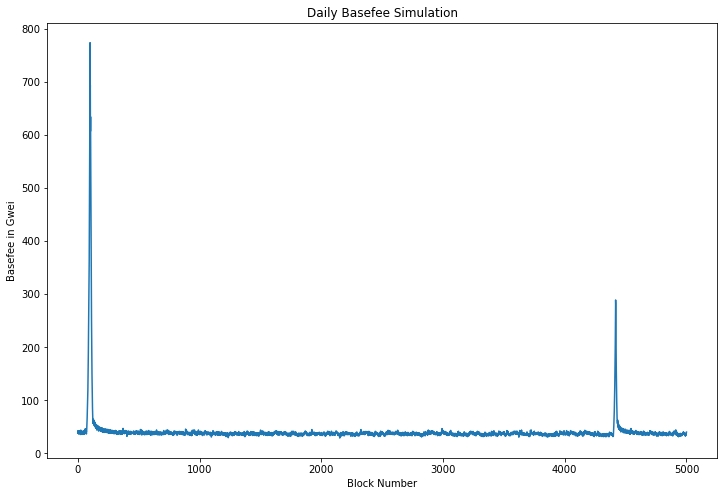

In [10]:
plt.rcParams["figure.figsize"] = (12,8)
plt.title("Daily Basefee Simulation")
plt.xlabel("Block Number")
plt.ylabel("Basefee in Gwei")
plt.plot(basefees_data);

- increase the number of txs and it's gas limit due to the (have to increase the user bid as well, in order to be included into the blockchain), from a bl beween 0-40
- asuumption: users stop bidding due to the high basefee, congestion or sold out of the NFT. decrease the txs to 0, and then the base fee are decreasing back to normal. 
- (in plan) after basefee dropped to a certain value (double of the increasing min, mean, or 50 gwei), go back to regular entering number of txs, and regular gas limit.